<a href="https://colab.research.google.com/github/Varchala/Secure_Private_AI/blob/main/android_malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are using [androguard](https://github.com/androguard/androguard) to perform apk analysis. We are using a small data set that is available on [kaggle](https://www.kaggle.com/xwolf12/datasetandroidpermissions). 

We will also use some live android malware as well as a (hopefully ;) ) clean android app. The cell below downloads the data we need through this notebook.


In [ ]:
!pip install androguard
!pip install tensorflow-gpu==1.15.2  keras==2.2.3 cleverhans==2.1.0
!wget https://github.com/duckduckgo/Android/releases/download/5.36.3/duckduckgo-5.36.3-release.apk
!wget 'https://docs.google.com/uc?export=download&id=1_eK_o1Jdp0K8lIVptcgfrn3x546bbc3d' -O android_permissions.csv
!wget https://github.com/ashishb/android-malware/raw/master/fake_bankers/eba335956afad3b50a93effc61cd7467552ff0f7c8ac14032f784c5fec3a5720.apk -O fake_banker.apk
!wget https://raw.githubusercontent.com/ashishb/android-malware/master/feabme/com.tinker.jumperchess\(Jump%20Chess\).apk -O feabme.apk
!wget https://github.com/ashishb/android-malware/raw/master/TrojanDownloader.Agent.JI/Google-play.apk -O TrojanDownloader.apk


Below is some help code that is mostly about data handling. It provides function to split the data in tow the two different classes as well as perform the test and train split.

In [2]:
def split_by_class(  x, y, MALWARE_LABEL=1, BEGING_LABEL=0 ):
  """
  Return two datasets. one for benign and one for malicious
  :param x:
  :param y:
  :return: (x_mal, y_mal), (x_beg, y_beg)
  """

  # saftey checks
  size = x.shape[ 0 ]
  assert (size == y.shape[ 0 ])

  # converted to category labels
  if hasattr( y[ 0 ], 'shape' ) and  len( y[0].shape) != 0 and y[ 0 ].shape[ 0 ] > 1:
    mal_label = to_categorical( MALWARE_LABEL, 2 )
    beg_label = to_categorical( BEGING_LABEL, 2 )
    # cause numpy is fun
    i_m = (y == mal_label).all( axis=1 ).nonzero( )[ 0 ]
    i_x = (y == beg_label).all( axis=1 ).nonzero( )[ 0 ]
  else:
    i_m = np.argwhere( y == MALWARE_LABEL )[ :, 0 ]
    i_x = np.argwhere( y == BEGING_LABEL )[ :, 0 ]

  x_mal = x[ i_m ][ : ]
  y_mal = y[ i_m ][ : ]

  x_beg = x[ i_x ][ : ]
  y_beg = y[ i_x ][ : ]

  print( 'Malware: ', x_mal.shape )
  print( 'Goodware: ', x_beg.shape )

  # saftey checks
  assert (size == x_mal.shape[ 0 ] + x_beg.shape[ 0 ])
  assert (size == y_mal.shape[ 0 ] + y_beg.shape[ 0 ])

  return (x_mal, y_mal), (x_beg, y_beg)


def training_and_test( x, y, split=0.75, balance_classes=False,
                      MALWARE_LABEL=1, BEGING_LABEL=0, **kwargs ):
  """
  Splits the data set into training set. If x or y is None the data is loaded 
  or processed.
  :param x:
  :param y:
  :param split: percentage of the training going into the training data
  :balance_classes: keep the ratio of classes in training and test set
  :return: (x_train, y_train), (x_test, y_test)
  """
  # safety checks
  size = x.shape[ 0 ]
  assert (size == y.shape[ 0 ])

  print( 'X: ', x.shape )
  print( 'Y: ', y.shape )

  rand = np.random.RandomState( )
  rand.seed( 7 )
  if balance_classes:
    (x_mal, y_mal), (x_beg, y_beg) = split_by_class( x, y )
    p_mal = rand.permutation( x_mal.shape[ 0 ] )
    p_beg = rand.permutation( x_beg.shape[ 0 ] )
    # training set
    print( y_beg[ p_beg ][ : int( x.shape[ 0 ] * split ) ].shape )
    x_train = np.vstack( (x_mal[ p_mal ][ : int( x_mal.shape[ 0 ] * split ) ],
                        x_beg[ p_beg ][ : int( x_beg.shape[ 0 ] * split ) ]) )
    if len( y.shape ) ==1 :
      y_train = np.concatenate( (y_mal[ p_mal ][ : int( x_mal.shape[ 0 ] * split ) ],
                            y_beg[ p_beg ][ : int( x_beg.shape[ 0 ] * split ) ]),
                            axis=None )
    else:
      y_train = np.vstack( (y_mal[ p_mal ][ : int( x_mal.shape[ 0 ] * split ) ],
                            y_beg[ p_beg ][ : int( x_beg.shape[ 0 ] * split ) ]) )
    # test set
    x_test = np.vstack( (x_mal[ p_mal ][ int( x_mal.shape[ 0 ] * split ): ],
                        x_beg[ p_beg ][ int( x_beg.shape[ 0 ] * split ): ]) )
    if len( y.shape ) ==1 :
      y_test = np.concatenate( (y_mal[ p_mal ][ int( x_mal.shape[ 0 ] * split ): ],
                          y_beg[ p_beg ][ int( x_beg.shape[ 0 ] * split ): ]),
                            axis=None )
    else:
      y_test = np.vstack( (y_mal[ p_mal ][ int( x_mal.shape[ 0 ] * split ): ],
                          y_beg[ p_beg ][ int( x_beg.shape[ 0 ] * split ): ]) )
  else:
    p = rand.permutation( x.shape[ 0 ] )
    x_train = x[ p ][ : int( x.shape[ 0 ] * split ) ]
    y_train = y[ p ][ : int( x.shape[ 0 ] * split ) ]
    x_test = x[ p ][ int( x.shape[ 0 ] * split ): ]
    y_test = y[ p ][ int( x.shape[ 0 ] * split ): ]

  print( 'X_train: ', x_train.shape, type( x_train ) )
  print( 'Y_train: ', y_train.shape, type( y_train ) )
  print( 'X_test: ', x_test.shape, type( x_test ) )
  print( 'Y_test: ', y_test.shape, type( y_test ) )
  # safety checks
  assert (size == x_train.shape[ 0 ] + x_test.shape[ 0 ])
  assert (size == y_train.shape[ 0 ] + y_test.shape[ 0 ])

  return (x_train, y_train), (x_test, y_test)


Description of the dataset

The data were obtained by a process that consisted to
 create a binary vector of **permissions** used for each application analyzed {1=used, 0=no used}.
Moreover, the samples of malware/benign were divided by "Type"; 1 malware and 0 non-malware.

In [ ]:
!head android_permissions.csv

Next we'll read in the csv file and parse it. the first line gives us the names of the permissions. After that each line represents an instance. A 1 indicates that a certain feature/permission is present while a 0 indicates that it is not. The last value of the line gives us the class. 

In [4]:
import numpy as np

with open( 'android_permissions.csv', 'r' ) as f:
  lines = f.readlines()

permissions = lines[ 0 ].split( ';' )[ :-1 ]
print( 'all knonw permissions' )
print( permissions )

x = [ ]
y = [ ]
for line in lines[ 1: ]:
    features = line.rstrip( '\n' ).split( ';' )
    arr = [ int( i ) for i in features[ : -1 ] ]
    x.append( arr )
    y.append(  int( features[ -1 ] ) )
f.close( )
x = np.array( x )
y = np.array( y )

(x_train, y_train), (x_test, y_test) = training_and_test( x, y, 
                                                         balance_classes=True)



all knonw permissions
['android', 'android.app.cts.permission.TEST_GRANTED', 'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE', 'android.os.cts.permission.TEST_GRANTED', 'android.permission.ACCESS_ALL_DOWNLOADS', 'android.permission.ACCESS_ALL_EXTERNAL_STORAGE', 'android.permission.ACCESS_BLUETOOTH_SHARE', 'android.permission.ACCESS_CACHE_FILESYSTEM', 'android.permission.ACCESS_CHECKIN_PROPERTIES', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.ACCESS_DRM_CERTIFICATES', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.ACCESS_FM_RADIO', 'android.permission.ACCESS_INPUT_FLINGER', 'android.permission.ACCESS_KEYGUARD_SECURE_STORAGE', 'android.permission.ACCESS_LOCATION_EXTRA_COMMANDS', 'android.permission.ACCESS_MOCK_LOCATION', 'android.permission.ACCESS_MTP', 'android.permission.ACCESS_NET

Before we dive into learning from the data. Let's take a look at it.

(298, 330)
(298,)
Malware:  (149, 330)
Goodware:  (149, 330)
MALWARE


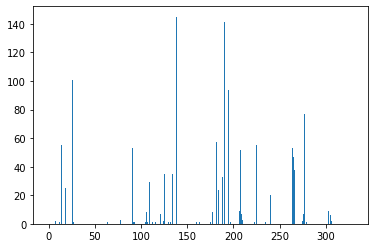

android.permission.INTERNET: 145
android.permission.READ_PHONE_STATE: 141
android.permission.ACCESS_NETWORK_STATE: 122
android.permission.ACCESS_WIFI_STATE: 101
android.permission.WRITE_EXTERNAL_STORAGE: 98
android.permission.READ_SMS: 94
android.permission.WRITE_SMS: 77
android.permission.RECEIVE_BOOT_COMPLETED: 77
android.permission.ACCESS_COARSE_LOCATION: 58
android.permission.READ_CONTACTS: 57
BENIGN


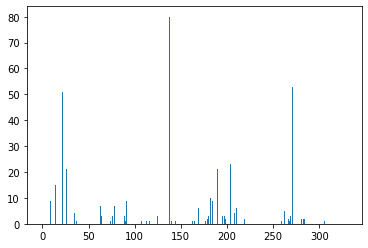

android.permission.INTERNET: 80
android.permission.WRITE_EXTERNAL_STORAGE: 53
android.permission.ACCESS_NETWORK_STATE: 51
android.permission.WAKE_LOCK: 28
android.permission.RECEIVE_BOOT_COMPLETED: 23
android.permission.READ_PHONE_STATE: 21
android.permission.ACCESS_WIFI_STATE: 21
android.permission.VIBRATE: 18
android.permission.ACCESS_FINE_LOCATION: 15
android.permission.READ_CONTACTS: 10


In [5]:
import matplotlib.pyplot as plt

print( x_train.shape )
print( y_train.shape )

(x_mal, y_mal), (x_beg, y_beg) = split_by_class( x_train, y_train )

print( 'MALWARE' )
mal = x_mal.sum( axis=0 )
plt.bar( np.arange( mal.shape[ 0 ] ), mal )
plt.show()
argsorted = np.flip( np.argsort( mal ) )
for i in range(10):
  print( permissions[ argsorted[ i ] ] + ': ' + str( mal[ argsorted[ i ] ] )  )

print( 'BENIGN' )
beg = x_beg.sum( axis=0 )
plt.bar( np.arange( beg.shape[ 0 ] ), beg )
plt.show()
argsorted = np.flip( np.argsort( beg ) )
for i in range(10):
  print( permissions[ argsorted[ i ] ] + ': ' + str( beg[ argsorted[ i ] ] )  )


Using what you have learned so far, create an SVM classifier (also any other classifier) using scikit-learn library, train it on that training data and evaluate it on the test data.

In [ ]:
# your code here
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf.fit(x_train, y_train)

In [20]:
y_pred=clf.predict(x_test)
# clf.score(x_test)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.94

In this task accuracy is not the most important measure. A more important way of measuring the effectiveness of our classifier is false negative and false positive rate. The function below allows us to compute it.

![img](http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

In [9]:
from sklearn.metrics import confusion_matrix

def metrics( y_true, y_pred ):
  # convert from categorial labels if required
  if len( y_pred[ 0 ].shape ) != 0:
    y_pred = np.argmax( y_pred, axis=1 )
  if len( y_true[ 0 ].shape ) != 0:
    y_true = np.argmax( y_true, axis=1 )
  tn, fp, fn, tp = confusion_matrix( y_true, y_pred, labels=[ 0, 1 ] ).ravel( )
  return { 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp }


In [21]:
print( clf.predict( x_test ) )
print( metrics( y_test, clf.predict( x_test ) ) )


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
{'tn': 46, 'fp': 4, 'fn': 2, 'tp': 48}


Let's see how our classifier work to new apks. We just downloaded a few at the beginning of the notebook. First we need to extract the permissions from the apk. 


In [11]:
from androguard.misc import AnalyzeAPK
import re

def extract_permissions( apk, dv_formant, analysis ):
  print( apk.get_app_name() )
  print( 'permissions' )
  apk_permissions = apk.get_permissions()
  print( apk_permissions )

  # create empty feature vector
  apk_features = np.zeros( [ len( permissions ) ] )

  for perm in apk_permissions:
    if not isinstance( perm, str ):
      continue
    try:
      idx = permissions.index( perm )
    except:
      print( 'encountered unknown permission:' + perm )  
    apk_features[ idx ] = 1

  return apk_features

def predict_svm( x ):
  print( clf.predict( x ) )
  

If we wanted to get more elaborate with our feature extraction. The code below extracts suspicious API calls and URL that are used in the app.


In [12]:
def suspicious_api_and_urls ( apk, dv_formant, analysis ):
  """
  taken from
  https://github.com/MLDroid/drebin
  """

  print( apk.get_app_name() )
  SuspiciousApiSet = set()
  URLDomainSet = set()
  for dv in dv_formant:
    for m in dv.get_methods():
      for block in analysis.get_method( m ).get_basic_blocks().get():
        DalvikCodeList = []
        for Instruction in block.get_instructions():
            CodeLine = str(Instruction.get_name() + " " + Instruction.get_output())
            DalvikCodeList.append(CodeLine)
        DalvikCodeList = set(DalvikCodeList)
        ApiList = []
        AndroidSuspiciousApiNameList = ["getExternalStorageDirectory", "getSimCountryIso", "execHttpRequest", 
                    "sendTextMessage", "getSubscriberId", "getDeviceId", "getPackageInfo", "getSystemService", "getWifiState", 
                    "setWifiEnabled", "setWifiDisabled", "Cipher"]
        OtherSuspiciousApiNameList = ["Ljava/net/HttpURLconnection;->setRequestMethod(Ljava/lang/String;)", "Ljava/net/HttpURLconnection", 
                                      "Lorg/apache/http/client/methods/HttpPost", "Landroid/telephony/SmsMessage;->getMessageBody", 
                                      "Ljava/io/IOException;->printStackTrace", "Ljava/lang/Runtime;->exec"]
        NotLikeApiNameList = ["system/bin/su", "android/os/Exec"]
        for DalvikCode in DalvikCodeList:
          if "invoke-" in DalvikCode:
              Parts = DalvikCode.split(",")
              for Part in Parts:
                  if ";->" in Part:
                      Part = Part.strip()
                      if Part.startswith('Landroid'):
                          FullApi = Part
                          ApiParts = FullApi.split(";->")
                          ApiClass = ApiParts[0].strip()
                          ApiName = ApiParts[1].split("(")[0].strip()
                          ApiDetails = {}
                          ApiDetails['FullApi'] = FullApi
                          ApiDetails['ApiClass'] = ApiClass
                          ApiDetails['ApiName'] = ApiName
                          ApiList.append(ApiDetails)
                          if(ApiName in AndroidSuspiciousApiNameList):
                              #ApiClass = Api['ApiClass'].replace("/", ".").replace("Landroid", "android").strip()
                              SuspiciousApiSet.add(ApiClass+"."+ApiName)
                  for Element in OtherSuspiciousApiNameList:
                      if(Element in Part):
                          SuspiciousApiSet.add(Element)
          for Element in NotLikeApiNameList:
              if Element in DalvikCode:
                  SuspiciousApiSet.add(Element)
        for Instruction in DalvikCodeList:
          URLSearch = re.search("https?://([\da-z\.-]+\.[a-z\.]{2, 6}|[\d.]+)[^'\"]*", Instruction, re.IGNORECASE)
          if (URLSearch):
              URL = URLSearch.group()
              Domain = re.sub("https?://(.*)", "\g<1>",
                              re.search("https?://([^/:\\\\]*)", URL, re.IGNORECASE).group(), 0, re.IGNORECASE)
              URLDomainSet.add(Domain)

  print( SuspiciousApiSet )
  print( URLDomainSet )
  return SuspiciousApiSet, URLDomainSet


Now that we have a trained classifier and a way to extract features from APK files we can see how are classifier perform on apps that were not part of the dataset.

Complete the code sub below to classify the apps.

In [ ]:
# list of apk filenames
apks =  [ 'duckduckgo-5.36.3-release.apk', 'fake_banker.apk', 'feabme.apk',
         'TrojanDownloader.apk' ]
# labels
labels = [ 0, 1, 1, 1 ]

# analyze the apks using an imported library
# for i in range(len(apks)):
a = [AnalyzeAPK(i) for i in apks]


In [32]:
apk_features = [extract_permissions(i[0],None,None)for i in a]
y_pred = clf.predict(apk_features) #.reshape(1, -1))
print(y_pred)
print("Score for {} is {}".format(apks,accuracy_score(labels, y_pred)))


# extract features using a defined function


# perform inference using the trained classifier (scikit learn)

DuckDuckGo
permissions
['android.permission.INTERNET', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.WRITE_EXTERNAL_STORAGE']
Ziraat 156.Yıl
permissions
['android.permission.RECEIVE_SMS', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_SMS', 'android.permission.INTERNET', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.SEND_SMS']
Jump Chess
permissions
['android.permission.ACCESS_NETWORK_STATE', 'android.permission.BLUETOOTH', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.INTERNET']
Google Play Services
permissions
['android.permission.SEND_SMS', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.INTERNET', 'android.permission.USES_POLICY_FORCE_LOCK', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.WAKE_LOCK', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.WRI

How does the classifier perform? Check against www.virustotal.com 
(You need to download and upload the files)


Download links:
https://github.com/duckduckgo/Android/releases/download/5.36.3/duckduckgo-5.36.3-release.apk

https://github.com/ashishb/android-malware/raw/master/fake_bankers/eba335956afad3b50a93effc61cd7467552ff0f7c8ac14032f784c5fec3a5720.apk

https://github.com/ashishb/android-malware/raw/master/feabme/com.tinker.jumperchess(Jump%20Chess).apk
or open https://github.com/ashishb/android-malware/blob/master/feabme/com.tinker.jumperchess(Jump%20Chess).apk

https://github.com/ashishb/android-malware/raw/master/TrojanDownloader.Agent.JI/Google-play.apk

Of course, we are not limited to SVMs for malware detection. We can use neural nets too.
The code below builds a and trains a simple neural network.

In [40]:
import tensorflow as tf

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical( y_train )  
y_test_cat = to_categorical( y_test )  

model = Sequential()
model.add( Dense( 64, activation='relu', input_shape=x_train.shape[ 1: ]  ) )
model.add( Dense( 32, activation='relu' ) )
model.add( Dense( 2, activation='softmax' ) )
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
# your code here
model.fit(x_train,y_train_cat,epochs=64)

298/298 [==============================] - 0s 115us/step - loss: 0.0385 - acc: 0.9933
Epoch 38/64
298/298 [==============================] - 0s 112us/step - loss: 0.0376 - acc: 0.9933
Epoch 39/64
298/298 [==============================] - 0s 85us/step - loss: 0.0366 - acc: 0.9933
Epoch 40/64
298/298 [==============================] - 0s 87us/step - loss: 0.0362 - acc: 0.9933
Epoch 41/64
298/298 [==============================] - 0s 95us/step - loss: 0.0348 - acc: 0.9933
Epoch 42/64
298/298 [==============================] - 0s 75us/step - loss: 0.0345 - acc: 0.9933
Epoch 43/64
298/298 [==============================] - 0s 85us/step - loss: 0.0337 - acc: 0.9933
Epoch 44/64
298/298 [==============================] - 0s 84us/step - loss: 0.0346 - acc: 0.9899
Epoch 45/64
298/298 [==============================] - 0s 79us/step - loss: 0.0327 - acc: 0.9933
Epoch 46/64
298/298 [==============================] - 0s 101us/step - loss: 0.0321 - acc: 0.9933
Epoch 47/64
298/298 [==================

How does the neural network perform when compared against our SVM classifier we trained earlier? 
Compare the relevant metrics on the test set and the 4 APKs we downloaded.

In [48]:
# evaluate model performance

print(model.evaluate(x_test,y_test_cat))
metrics(y_test,model.predict(x_test))


100/100 [==============================] - 0s 155us/step
[0.17831587915774436, 0.97]


{'fn': 1, 'fp': 2, 'tn': 48, 'tp': 49}

In [49]:
model.predict(np.array(apk_features))

array([[9.9525368e-01, 4.7462853e-03],
       [7.2407880e-04, 9.9927598e-01],
       [9.9999046e-01, 9.5355290e-06],
       [3.7188679e-06, 9.9999630e-01]], dtype=float32)

Of course the neural model is vulnerable to same attacks we discussed earlier. But in the malware setting we are not free to make any change we want.
We need to constrain ourselves, so we can "easily" make the modifications to the APK without changing its functionality. A common constraint is to only add features.

Another constraint is that we can only make a change of exactly 1 since our features are binary. There is no 0.1 change. It is only on or off.
We deal with this by rounding up our down in the code below.

For the moment lets ignore the first constraint.

Let's build a simple FGSM attack with rounding and attack the model we trained above.


In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

In [53]:
import tensorflow as tf
from cleverhans.utils_tf import model_loss
import keras

eps = .1 # rate of change
alpha = 0.5 # threshold for rounding

# we don't want training phase behaviour
keras.layers.core.K.set_learning_phase( 0 )

# Set TF random seed to improve reproducibility
tf.set_random_seed( 1234 )

# we need the tensorflow session to run the attack
sess = keras.backend.get_session()

# compute natural loss
x_tensor = tf.convert_to_tensor(x_test,np.float32)
preds= model(x_tensor)
# forward pass


# compute gradient


# find next sample


# make sure we are in the correct range


# rounding


# compute adversarial loss
loss_adv = model_loss( y_test_cat, model( x_tensor ), mean=False )

# run the attack
x_adv = sess.run( x_tensor )


print( 'changes that were made' )
print( np.sum( x_adv, axis=1 ) - np.sum( x_test, axis=1 ) )


NameError: ignored

How does the attack perform? Evaluate the created examples.

In [ ]:
# your code here



A more powerful version of the attack is an iterative version. Modify the code above to make the attack iterative. Additionally, the attack currently still regards our first constraint. How would that be changed?


In [ ]:
# your code here


It is time to analyze the adversarial examples that we have created. Using code from earlier check which features where added the most often. Also do the samples work against the SVM classifier?

Further exercise: with the androguard tool you can repakage apks. Make the changes to the manifest suggested by the adversarial examples, repakage the apk and see how it fares against virustotal.
